# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

from scipy.stats import pearsonr, chi2_contingency

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df = pd.read_csv('/kaggle/input/supply-chain-dataset/supply_chain_data.csv')

df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

In [3]:
df.head(10)

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632
5,haircare,SKU5,1.699976,87,147,2828.348746,Non-binary,90,27,66,...,Bangalore,10,104,17,56.766476,Fail,2.779194,Road,Route A,235.461237
6,skincare,SKU6,4.078333,48,65,7823.476560,Male,11,15,58,...,Kolkata,14,314,24,1.085069,Pending,1.000911,Sea,Route A,134.369097
7,cosmetics,SKU7,42.958384,59,426,8496.103813,Female,93,17,11,...,Bangalore,22,564,1,99.466109,Fail,0.398177,Road,Route C,802.056312
8,cosmetics,SKU8,68.717597,78,150,7517.363211,Female,5,10,15,...,Mumbai,13,769,8,11.423027,Pending,2.709863,Sea,Route B,505.557134
9,skincare,SKU9,64.015733,35,980,4971.145988,Unknown,14,27,83,...,Chennai,29,963,23,47.957602,Pending,3.844614,Rail,Route B,995.929461


In [4]:
# Handle missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

df.shape

(100, 24)

# Data Visualization

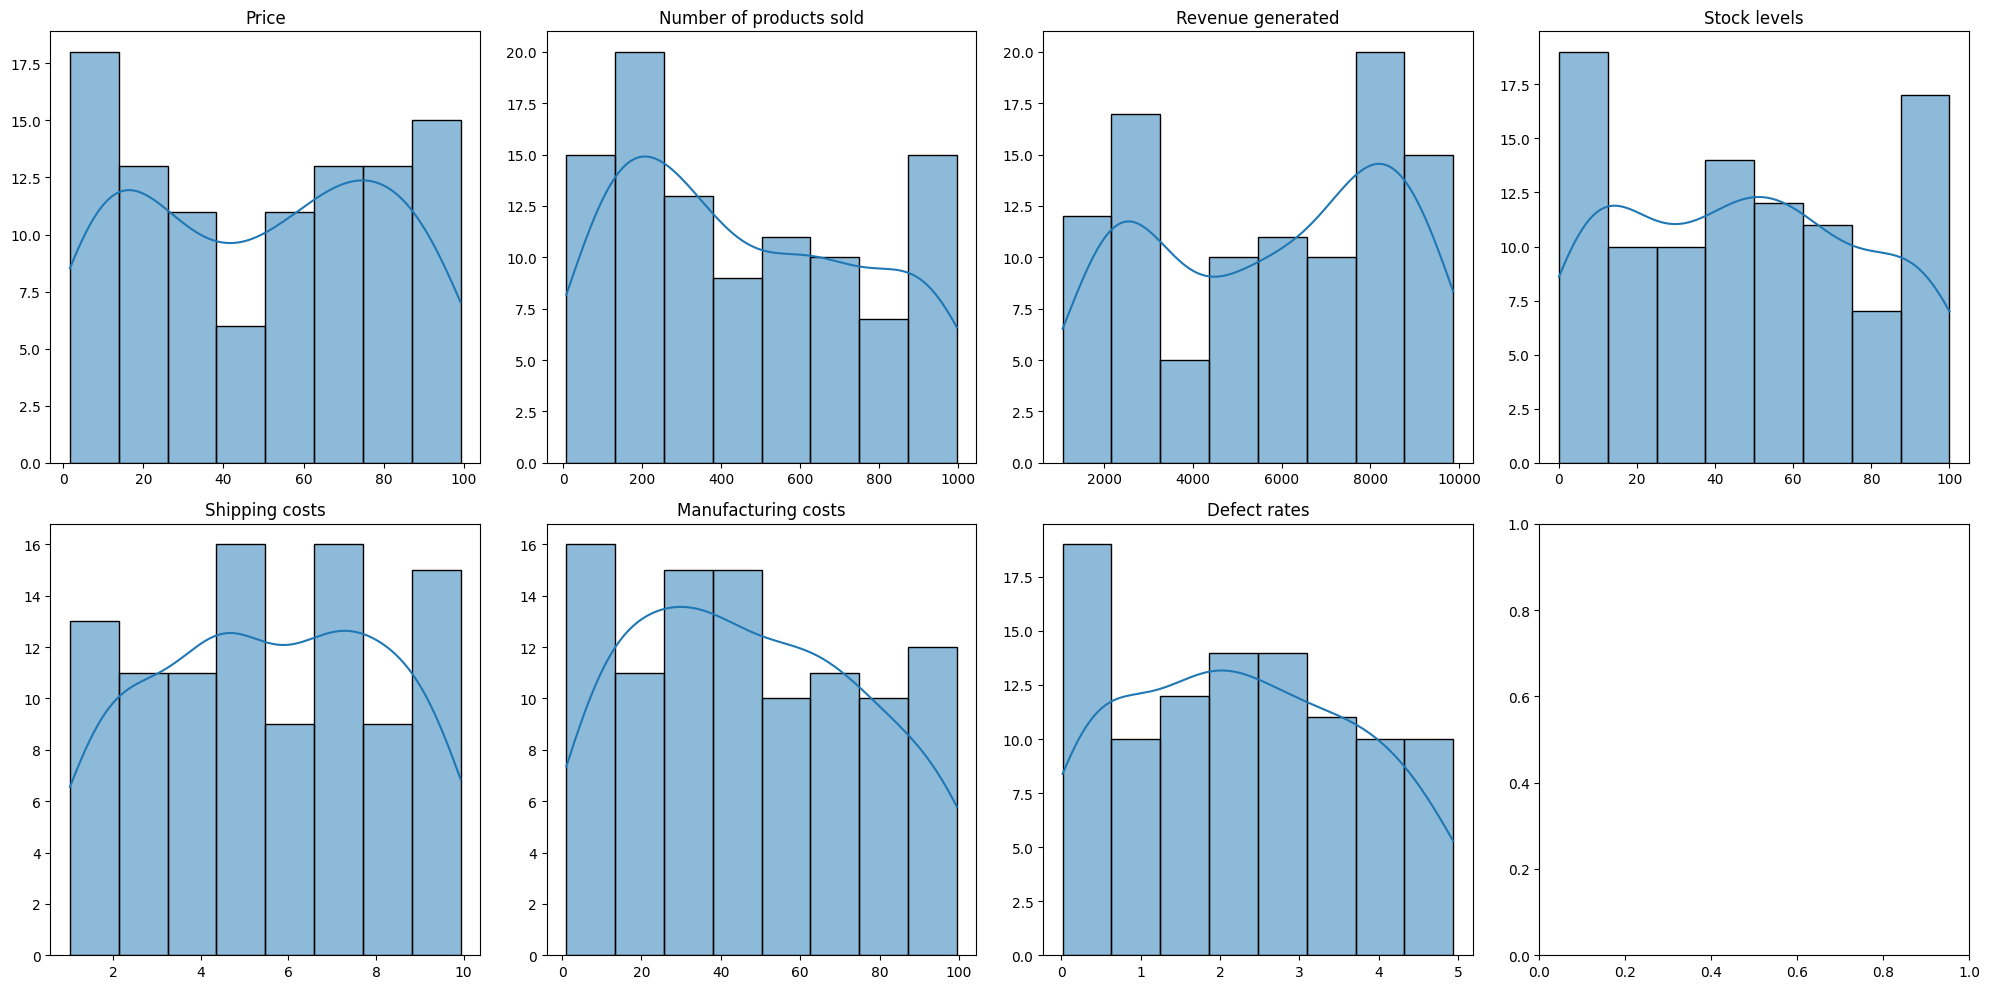

In [5]:
# Selecting columns for visualization
selected_columns = ['Price', 'Number of products sold', 'Revenue generated', 'Stock levels', 
                    'Shipping costs', 'Manufacturing costs', 'Defect rates']

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Flatten the axes array
axes = axes.flatten()

# Plotting each selected column
for i, column in enumerate(selected_columns):
    sns.histplot(df[column], ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

# Statistical Analysis

In [6]:
# Summary statistics
print(df.describe())

            Price  Availability  Number of products sold  Revenue generated  \
count  100.000000    100.000000               100.000000         100.000000   
mean    49.462461     48.400000               460.990000        5776.048187   
std     31.168193     30.743317               303.780074        2732.841744   
min      1.699976      1.000000                 8.000000        1061.618523   
25%     19.597823     22.750000               184.250000        2812.847151   
50%     51.239831     43.500000               392.500000        6006.352023   
75%     77.198228     75.000000               704.250000        8253.976921   
max     99.171329    100.000000               996.000000        9866.465458   

       Stock levels  Lead times  Order quantities  Shipping times  \
count    100.000000  100.000000        100.000000      100.000000   
mean      47.770000   15.960000         49.220000        5.750000   
std       31.369372    8.785801         26.784429        2.724283   
min        0

In [7]:
# Frequency distribution for categorical variables
categorical_variables = ['Product type', 'Customer demographics', 'Shipping carriers', 'Supplier name', 'Location', 'Inspection results', 'Transportation modes', 'Routes']
frequency_distribution = {}

for col in categorical_variables:
    frequency_distribution[col] = df[col].value_counts()

print("\nFrequency Distribution for Categorical Variables:")
for col, freq_dist in frequency_distribution.items():
    print(f"\n{col}:")
    print(freq_dist)


Frequency Distribution for Categorical Variables:

Product type:
Product type
skincare     40
haircare     34
cosmetics    26
Name: count, dtype: int64

Customer demographics:
Customer demographics
Unknown       31
Female        25
Non-binary    23
Male          21
Name: count, dtype: int64

Shipping carriers:
Shipping carriers
Carrier B    43
Carrier C    29
Carrier A    28
Name: count, dtype: int64

Supplier name:
Supplier name
Supplier 1    27
Supplier 2    22
Supplier 5    18
Supplier 4    18
Supplier 3    15
Name: count, dtype: int64

Location:
Location
Kolkata      25
Mumbai       22
Chennai      20
Bangalore    18
Delhi        15
Name: count, dtype: int64

Inspection results:
Inspection results
Pending    41
Fail       36
Pass       23
Name: count, dtype: int64

Transportation modes:
Transportation modes
Road    29
Rail    28
Air     26
Sea     17
Name: count, dtype: int64

Routes:
Routes
Route A    43
Route B    37
Route C    20
Name: count, dtype: int64


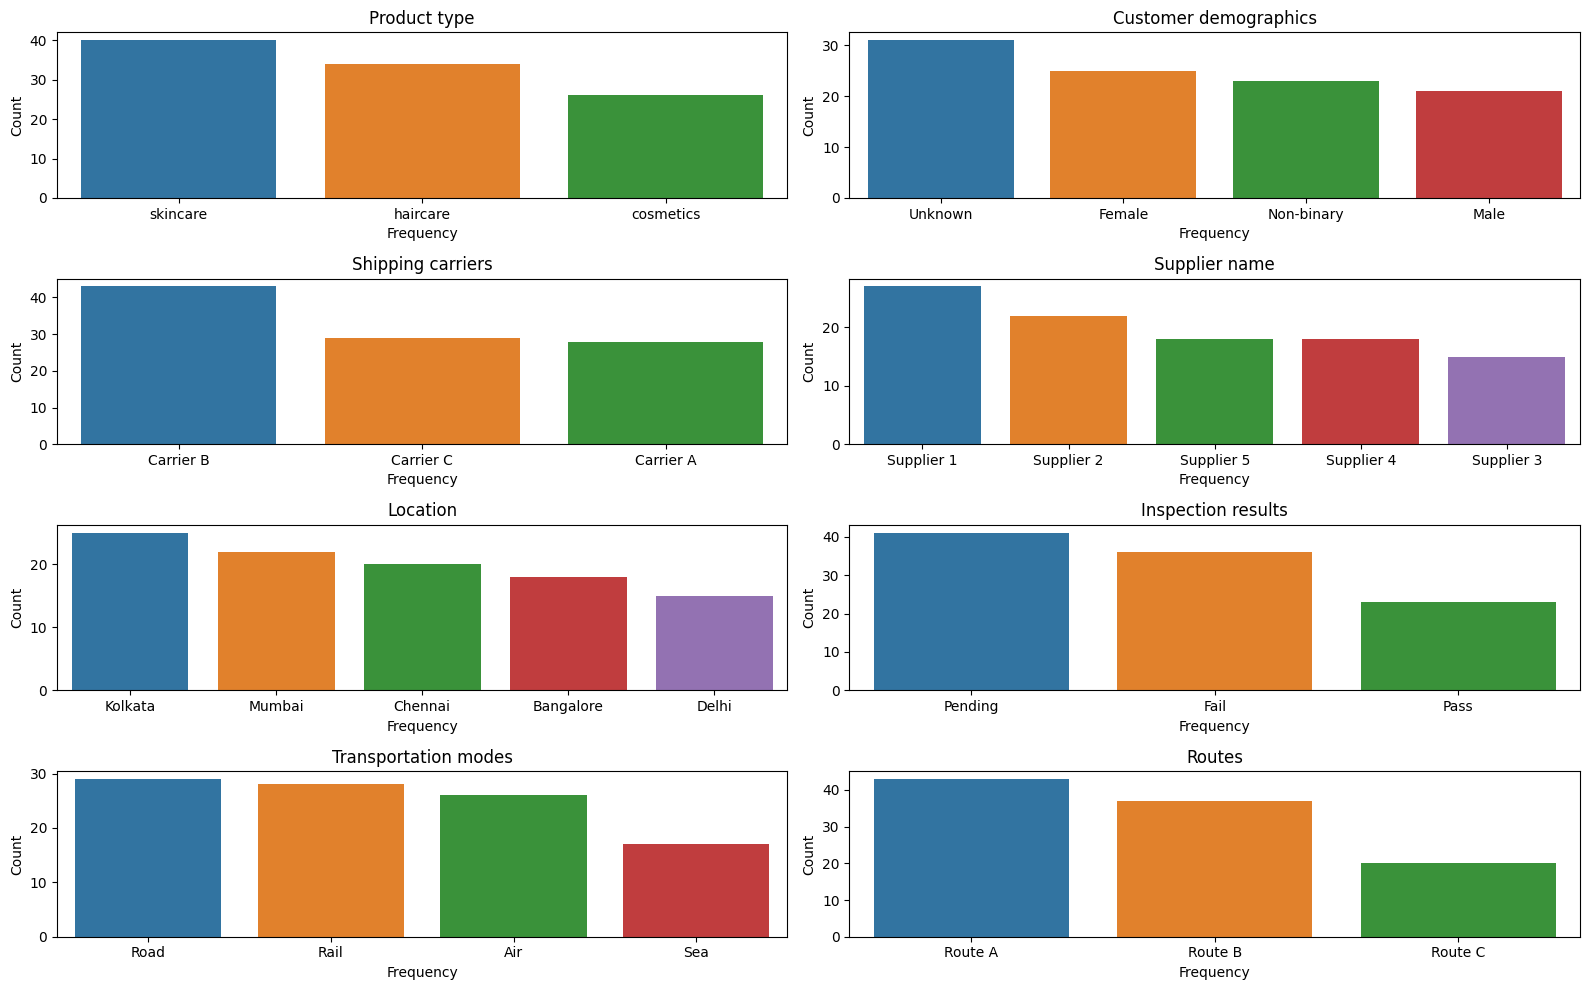

In [8]:

# Create subplots for each categorical variable
num_plots = len(categorical_variables)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Number of rows in the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))
axes = axes.flatten()

# Plot each categorical variable distribution
for i, (col, freq_dist) in enumerate(frequency_distribution.items()):
    ax = axes[i]
    sns.barplot(x=freq_dist.index, y=freq_dist.values, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x')  # Rotate x-axis labels for better readability

# Hide empty subplots if there are any
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


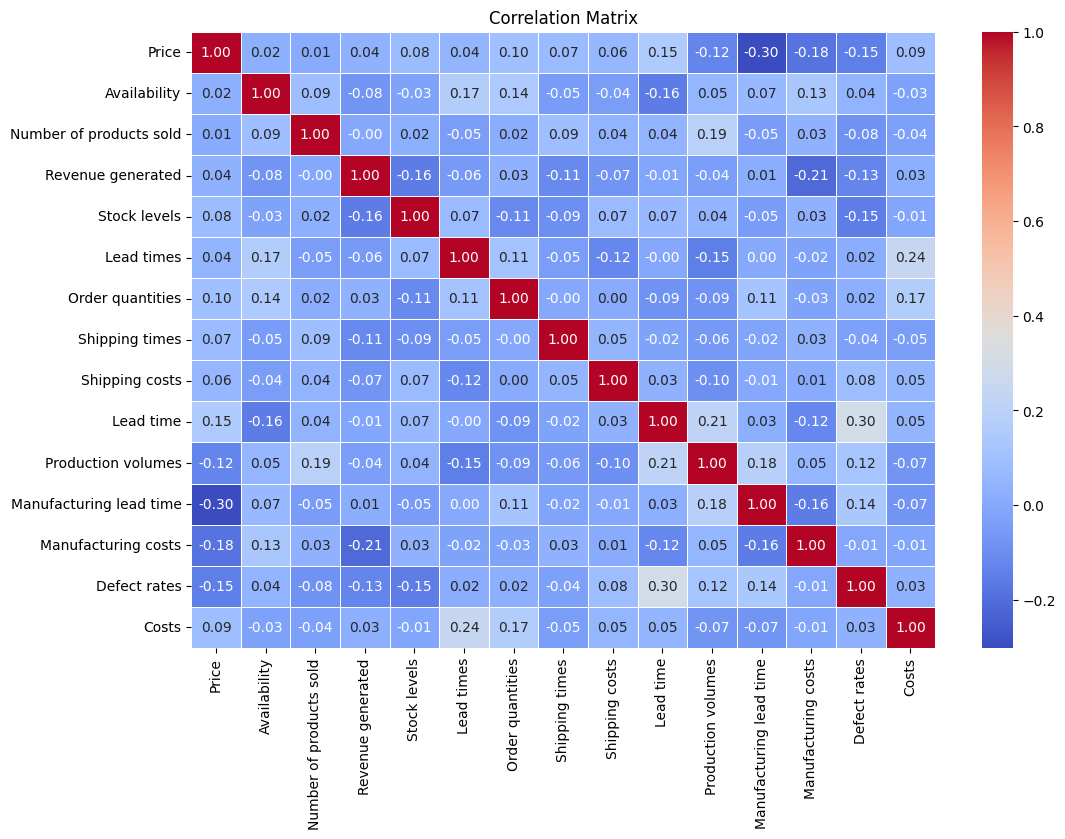

In [9]:
# Define numerical variables and compute correlation matrix
numerical_variables = ['Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping costs', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Defect rates', 'Costs']
correlation_matrix = df[numerical_variables].corr(method='pearson')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Categorical variable analysis
chi_square_results = {}

for col in categorical_variables:
    contingency_table = pd.crosstab(df[col], columns='count')
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = {'chi2_statistic': chi2, 'p_value': p}
    
print("\nCategorical Variable Analysis (Chi-square test):")
for col, result in chi_square_results.items():
    print(f"\n{col}:")
    print("Chi-square Statistic:", result['chi2_statistic'])
    print("p-value:", result['p_value'])


Categorical Variable Analysis (Chi-square test):

Product type:
Chi-square Statistic: 0.0
p-value: 1.0

Customer demographics:
Chi-square Statistic: 0.0
p-value: 1.0

Shipping carriers:
Chi-square Statistic: 0.0
p-value: 1.0

Supplier name:
Chi-square Statistic: 0.0
p-value: 1.0

Location:
Chi-square Statistic: 0.0
p-value: 1.0

Inspection results:
Chi-square Statistic: 0.0
p-value: 1.0

Transportation modes:
Chi-square Statistic: 0.0
p-value: 1.0

Routes:
Chi-square Statistic: 0.0
p-value: 1.0


# PuLP Optimization

In [11]:
# Define the problem
prob = pulp.LpProblem("Shipping_Optimization", pulp.LpMinimize)

# Define decision variables
# Let's define a binary variable for each product indicating whether to include it in the order or not
# 1 if the product is ordered, 0 otherwise
order_vars = {i: pulp.LpVariable(f"Order_{i}", cat='Binary') for i in range(len(df))}

# Define objective function
prob += pulp.lpSum(df['Shipping costs'][i] * order_vars[i] for i in range(len(df)))

# Define the maximum shipping time and total available stock level
max_shipping_time = 100  # hours
total_available_stock = 500  # units

# Add constraints
# Constraint: Total shipping time should not exceed a certain threshold
prob += pulp.lpSum(df['Shipping times'][i] * df['Order quantities'][i] * order_vars[i] for i in range(len(df))) <= max_shipping_time

# Constraint: Total order quantities should not exceed available stock levels
prob += pulp.lpSum(df['Order quantities'][i] * order_vars[i] for i in range(len(df))) <= total_available_stock

# Solve the problem
prob.solve()



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/aeb30cc2274846b6b7a3d7fee2e1eb43-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/aeb30cc2274846b6b7a3d7fee2e1eb43-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 508 RHS
At line 511 BOUNDS
At line 612 ENDATA
Problem MODEL has 2 rows, 100 columns and 200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
Gomory was tried 0 times and created 0 cuts of which

1

In [12]:
# Review the Decision Variables
print("Ordered Products:")
for var in prob.variables():
    if var.varValue > 0:
        print(var.name, "=", var.varValue)

# Check Constraints
total_shipping_time = sum(df['Shipping times'][i] * df['Order quantities'][i] * order_vars[i].varValue for i in range(len(df)))
total_ordered_quantities = sum(df['Order quantities'][i] * order_vars[i].varValue for i in range(len(df)))
print("Total Shipping Time:", total_shipping_time)
print("Total Ordered Quantities:", total_ordered_quantities)

# Analyze Shipping Costs
print("Shipping Costs:")
for i in range(len(df)):
    if order_vars[i].varValue > 0:
        print("Product:", df['SKU'][i], "Shipping Cost:", df['Shipping costs'][i])

# Inspect the Objective Function
print("Objective Value:", pulp.value(prob.objective))


Ordered Products:
Total Shipping Time: 0.0
Total Ordered Quantities: 0.0
Shipping Costs:
Objective Value: 0.0
